In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
from astropy.units import cds
cds.enable()
import pandas as pd

In [2]:
latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325.0 * u.Pa
g = c.g0
R0 = c.R
T0 = 19. * u.deg_C
lapserate = -6.5 * u.deg_C / u.km
M = 0.0289644 * u.km/u.mol

In [3]:
temperature = T0 + (lapserate*altitude)
temperatureK = temperature.to(u.K, equivalencies=u.temperature())

exponent = (-(g * M * altitude)/(R0 * temperatureK)).value
pressure = (p0 * np.exp(exponent)).to(u.Pa)
humidity = 40.

# Problem 1
## Problem 1A

In [4]:
# calculating vapor pressure variable listed as p_w in paper
def calcpw(RH, tin):
    t = tin.value
    x = np.log(RH/100)
    dewpoint = (238.3 * (((t + 238.3)*x + (17.2694*t)) / ((t+238.3)*(17.2694 - x) - (17.2694 * t)))) * u.deg_C
    td = dewpoint.value
    pw = (4.50874 + (0.341724*td**2) + (0.184889*10**-3 * td**3) + (0.238294*10**-5 * td**4) + (0.203447*10**-7 * td**5)) * u.cds.mmHg
    return pw
Pw = calcpw(humidity, temperature).to(u.cds.mbar)

In [10]:
T = temperatureK
Ps = pressure.to(u.cds.mbar) # Dry air pressure in millibars
print(Ps, Pw)

729.2533850673419 mbar 54.94327520933853 mbar


In [11]:
# calculating n with given variables
def calcindex(Tin, PSin, PWin, wavelength):
    T = Tin.value
    PS = PSin.value
    PW = PWin.value
    sig = (10**4 / (wavelength.to(u.um))).value
    Dw = (1+PW*(1+3.7*10**-4 * PW)*(-2.37321*10**-3 + (2.23366/T) - (710.792/T**2) + (7.75141*10**4 / T**3))) * (PW/T)
    Ds = (1+PS*(57.90*10**-8 - (9.3250*10**-4/T) + (0.25844/T**2)))*(PS/T)
    n = (((2371.34 + (683939.7/(130-sig**2)) + (4547.3/(38.9-sig**2)))*Ds + (6487.31 + 58.058*sig**2 - 0.71150*sig**4 + 0.08851*sig**6)*Dw) / (10**-8)) + 1
    return n

def calcBeta(temp):
    result = 0.001254*((temp.to(u.K))/(273.15*u.K))
    return result

def calcKappa(phideg, h):
    phi = (phideg.to(u.rad)).value
    result = 1 + 0.005302*np.sin(phi)**2 - 0.00000583*np.sin(2*phi)**2 - 0.000000315*h.value
    return result

def calcRefrac(n0, beta, k, z):
    z0 = z.to(u.rad)
    gamma = n0 - 1
    result = ((k * gamma*(1-beta)*np.tan(z0)) - (k * gamma * (beta - 0.5*gamma)*(np.tan(z0)**3)))
    return result

# Problem 2
## Problem 2A

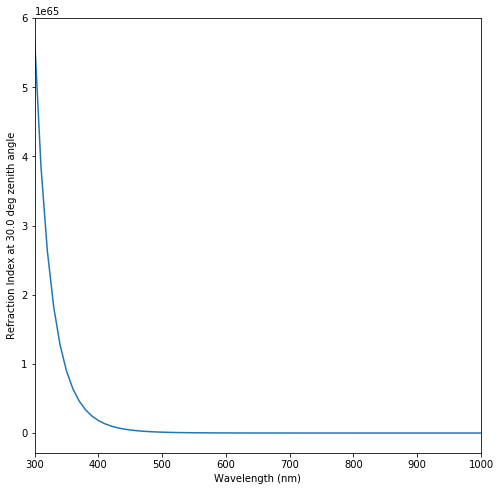

In [12]:
step = 10
wavelengths = np.arange(300, 1000+step, step)*u.nm
B = calcBeta(temperatureK)
K = calcKappa(latitude, altitude)
n = calcindex(T, Ps, Pw, wavelengths)
R = calcRefrac(n, B, K, 30*u.deg)

def pltRefrac(wavelength, n_in, B_in, K_in, z_in, minwl=None, maxwl=None):
    Refrac = calcRefrac(n_in, B_in, K_in, z_in)
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.plot(wavelength, Refrac)
    wl_min = minwl if minwl is not None else np.min(wavelength)
    wl_max = maxwl if maxwl is not None else np.max(wavelength)
    ax.set_xlim(wl_min.value, wl_max.value)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel(f'Refraction Index at {z_in} zenith angle')
    plt.show()

pltRefrac(wavelengths, n, B, K, 30*u.deg)

## Problem 2B

[0.0, 1.9812855783609592e+63, 1.6219895226733353e+64, 5.691792889909474e+64, 1.4265576794876767e+65, 2.999917940040817e+65, 5.693900181160792e+65, 1.0157154936500422e+66, 1.7479633483049813e+66, 2.9586373220988373e+66, 5.007848026221247e+66, 8.618097152638444e+66, 1.5373530489134126e+67, 2.917924749500676e+67]


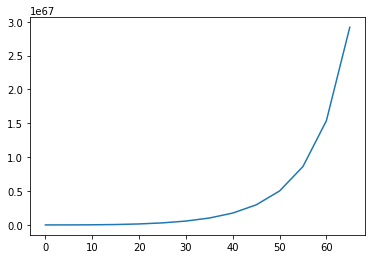

In [13]:
# min and max wavelengths in g- and i- bands
gband = pd.read_csv('throughputs/baseline/total_g.dat', sep=' ', header=7)
gband.columns = ['Wavelength','Throughput']
gWavelength = np.asarray(gband['Wavelength'][0:7755])*u.nm
gThroughput = gband['Throughput'][0:7755]

iband = pd.read_csv('throughputs/baseline/total_i.dat', sep=' ', header=7)
iband.columns = ['Wavelength', 'Throughput']
iWavelength = np.asarray(iband['Wavelength'][0:7755])*u.nm
iThroughput = iband['Throughput'][0:7755]

gmin = 386.30*u.nm
gmax = 567.00*u.nm
imin = 675.90*u.nm
imax = 833.00*u.nm

angles = np.arange(0, 70, 5)*u.deg
gbandN = calcindex(T, Ps, Pw, gWavelength)
gbandR = []
for angle in angles:
    gbandR.append(np.max(calcRefrac(gbandN, B, K, angle)).value)
print(gbandR)

fig, ax = plt.subplots(1,1)
ax.plot(angles, gbandR)
plt.show()